In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MedHouseVal')

print("Dataset Shape:", X.shape)
print("\nFeatures:", X.columns.tolist())
print("\nTarget variable: Median House Value (in $100,000s)")

Dataset Shape: (20640, 8)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target variable: Median House Value (in $100,000s)


In [3]:
print("\nMissing Values")
print(X.isnull().sum())


Missing Values
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


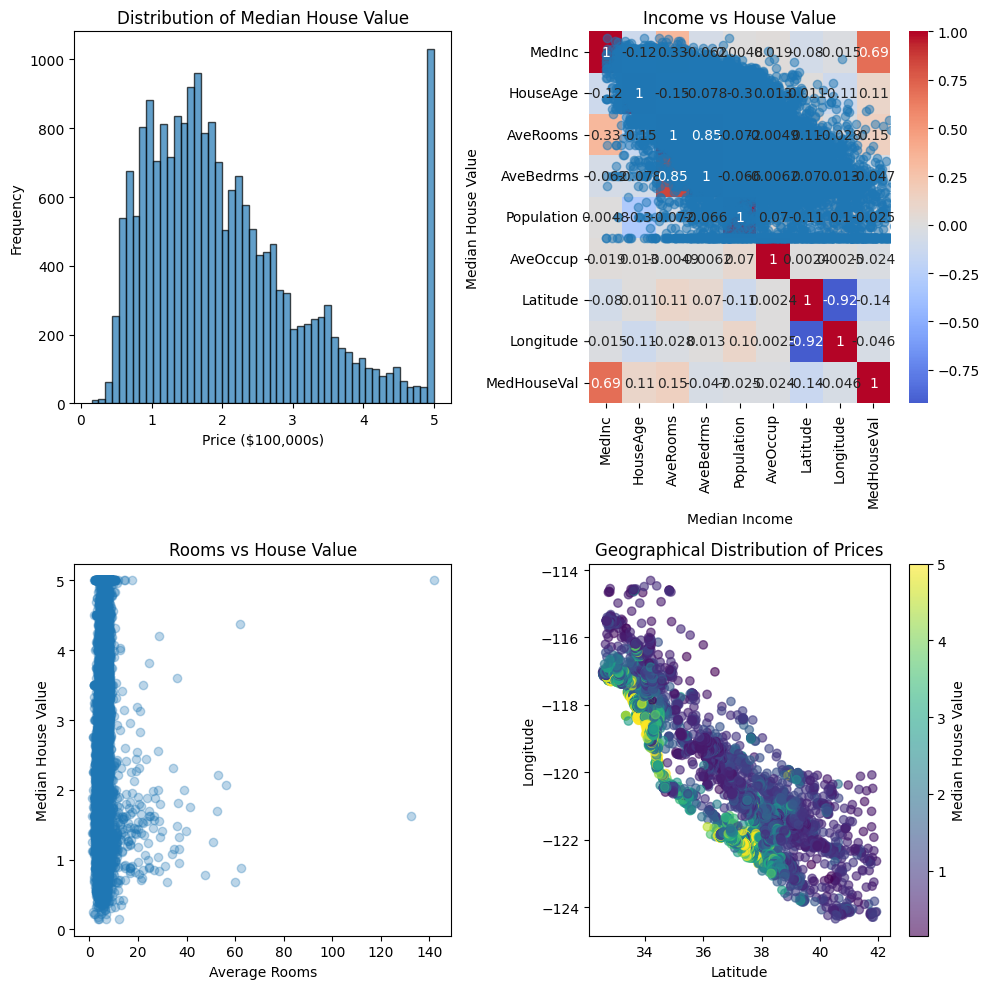

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Median House Value')
plt.xlabel('Price ($100,000s)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
correlation_matrix = pd.concat([X, y], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.scatter(X['MedInc'], y, alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Income vs House Value')

plt.subplot(2, 3, 4)
plt.scatter(X['AveRooms'], y, alpha=0.3)
plt.xlabel('Average Rooms')
plt.ylabel('Median House Value')
plt.title('Rooms vs House Value')

plt.subplot(2, 3, 5)
plt.scatter(X['Latitude'], X['Longitude'], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(label='Median House Value')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geographical Distribution of Prices')

plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

Training set size: (16512, 8)
Test set size: (4128, 8)


In [8]:
baseline_dt = DecisionTreeRegressor(random_state=42)
baseline_dt.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_dt.predict(X_test_scaled)

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n{model_name} Performance")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

baseline_metrics = evaluate_model(y_test, y_pred_baseline, "Baseline Decision Tree")

y_train_pred = baseline_dt.predict(X_train_scaled)
train_metrics = evaluate_model(y_train, y_train_pred, "Baseline Decision Tree (Training)")


Baseline Decision Tree Performance
Mean Squared Error (MSE): 0.4940
Root Mean Squared Error (RMSE): 0.7028
Mean Absolute Error (MAE): 0.4539
R² Score: 0.6230

Baseline Decision Tree (Training) Performance
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R² Score: 1.0000


In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

print("Performing Grid Search...")
grid_search = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {-grid_search.best_score_:.4f}")

best_dt = grid_search.best_estimator_
y_pred_tuned = best_dt.predict(X_test_scaled)

tuned_metrics = evaluate_model(y_test, y_pred_tuned, "Tuned Decision Tree")

Performing Grid Search...
Fitting 5 folds for each of 336 candidates, totalling 1680 fits

Best Parameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20, 'random_state': 42}
Best Cross-Validation Score: 0.3741

Tuned Decision Tree Performance
Mean Squared Error (MSE): 0.3666
Root Mean Squared Error (RMSE): 0.6055
Mean Absolute Error (MAE): 0.4051
R² Score: 0.7202


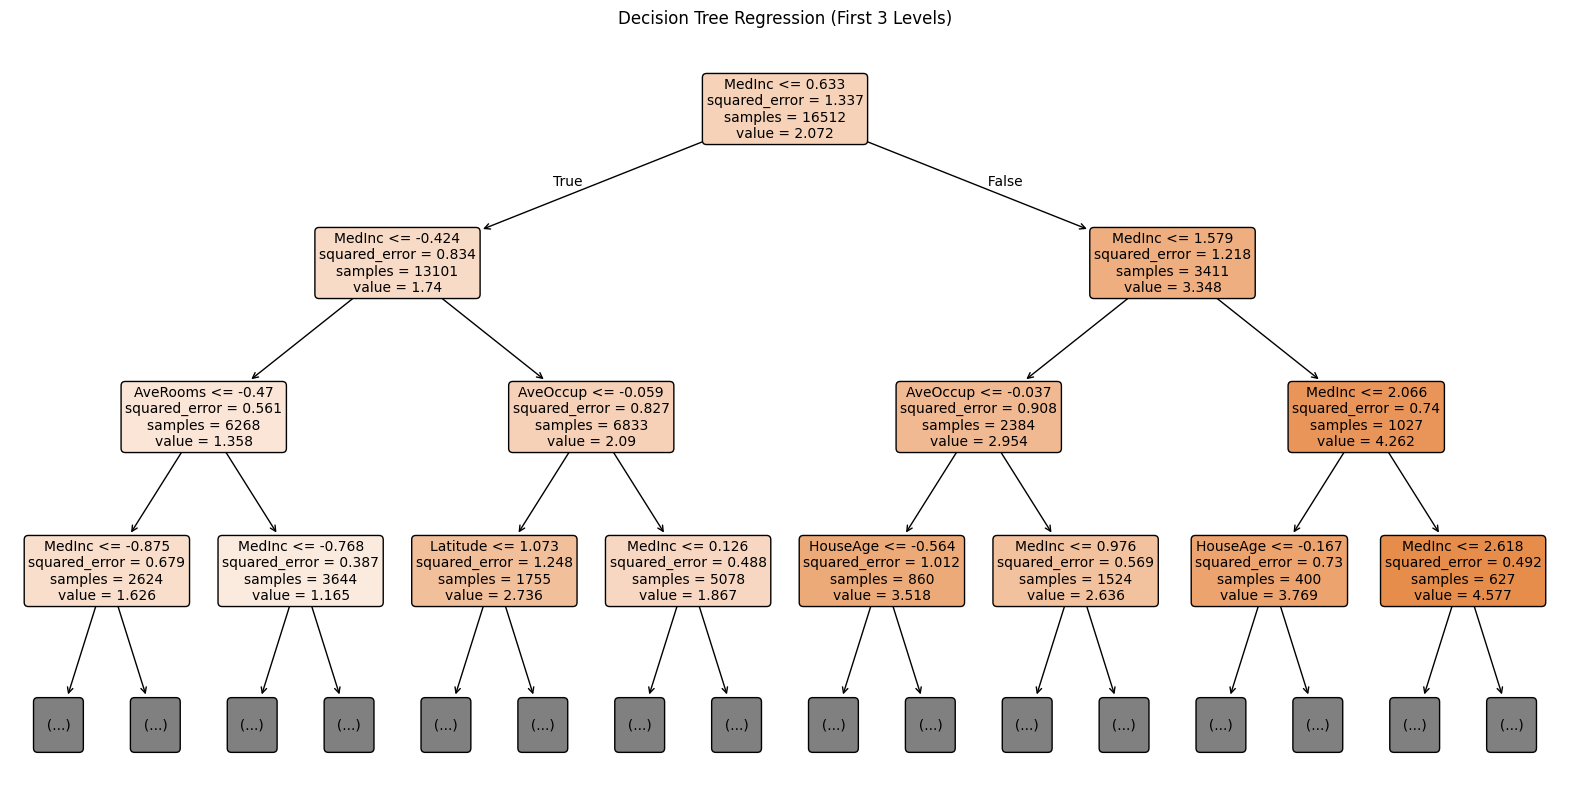


=== Feature Importance ===
      feature  importance
0      MedInc    0.592857
5    AveOccup    0.130724
6    Latitude    0.087879
7   Longitude    0.075680
1    HouseAge    0.047571
2    AveRooms    0.039311
3   AveBedrms    0.014111
4  Population    0.011867


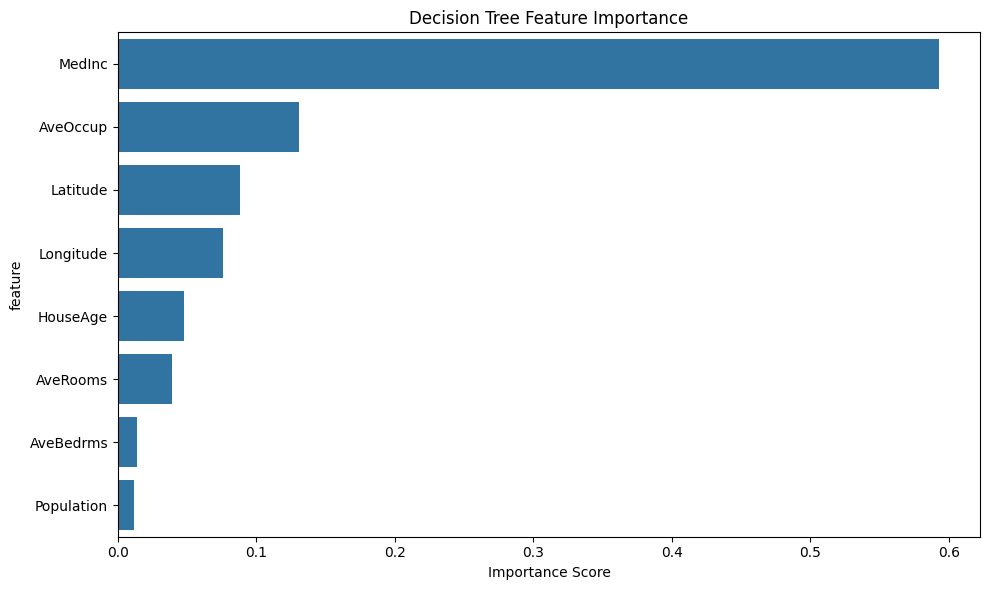

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          feature_names=X.columns,
          filled=True, 
          rounded=True,
          max_depth=3,  
          fontsize=10)
plt.title('Decision Tree Regression (First 3 Levels)')
plt.show()

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()